**Engy-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2024; Prof. V. F. de Almeida

# Discussion On Test Two

**Student(s):**  Kyle Mills and Billy Manco and Donaita Anglade <br>
**Course:** Engy-4390: Nuclear Systems Design and Analysis  <br>
**Mentor and Collaborator:** Subash Sharma

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**21 Oct 2024**

---
## Table of Contents<a id="toc"></a>
* [What is a Robin BC](#whatisit)
* [Definitions](#defs)
* [Setup](#setup)
* [Test](#test)
---

## [Definition of the necessary functions](#toc)<a id="defs"></a>

In [139]:
'''Generate the target function f'''
import matplotlib.pyplot as plt
import math as m
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import quad

## [Setup](#toc)<a id="setup"></a>

In [141]:
'''Domain'''
'''Rayleigh Ritz Method with Lagrange FE Basis Functions'''
x_min=0
x_max=0.05

degree = 2  #Degree of the lagrange polinomials used
n_elem = 10 #Number of elements used

In [142]:
'''Domain partition'''
def get_domain_partition(degree, n_elem, x_min, x_max, bc_x_min='essential', bc_x_max='essential'):
    #assert degree == 1
    # Local node numbering on parent domain
    # --0--------------1---->
    #  -1      0      +1    zetta
    gnodes_x = np.linspace(x_min, x_max, n_elem*degree+1, dtype=np.float64)
    patches = list()
    local_to_global_node_id_map = list()
    for e in range(n_elem):
        gnode_id_1 = degree*e   #left
        gnode_id_2 = degree*e+1 #center
        gnode_id_3 = degree*e+2 #right
        x1 = gnodes_x[gnode_id_1]
        x2 = gnodes_x[gnode_id_2]
        x3 = gnodes_x[gnode_id_3]
        # Local node id:  0   1
        patches.append((x1, x2, x3))
        # Local node id:                        0           2             1
        local_to_global_node_id_map.append([gnode_id_1, gnode_id_2,  gnode_id_3])
    if bc_x_min == 'essential':
        local_to_global_node_id_map[0][0] = -1
    if bc_x_max == 'essential':
        local_to_global_node_id_map[-1][-1] = -1
    return (patches, gnodes_x, local_to_global_node_id_map)

In [143]:
'''Parent mapping'''
def get_parent_mapping():
    # zetta in [-1,1]
    parent_mapping = lambda zetta, x_e_bar, h_e: x_e_bar + h_e/2*zetta # compute x
    parent_mapping_prime = lambda h_e: h_e/2                           # compute mapping derivative wrt zetta
    # x in Omega_e
    inverse_parent_mapping = lambda x, x_e_bar, h_e: (x - x_e_bar)*2/h_e # compute zetta
    return (parent_mapping, parent_mapping_prime, inverse_parent_mapping)

In [144]:
'''The basis functions'''
def get_parent_basis_functions():
    parent_basis_func_list = list()
    parent_basis_func_prime_list = list()
    parent_basis_func_list.append(lambda zetta: (zetta**2-zetta)/2)  # left
    parent_basis_func_list.append(lambda zetta: -(zetta**2-1))  # middle
    parent_basis_func_list.append(lambda zetta:  (zetta**2+zetta)/2)  # right
    parent_basis_func_prime_list.append(lambda zetta: (2*zetta-1)/2) # left
    parent_basis_func_prime_list.append(lambda zetta: -2*zetta) # middle
    parent_basis_func_prime_list.append(lambda zetta:  (2*zetta+1)/2) # right
    return (parent_basis_func_list, parent_basis_func_prime_list)

In [145]:
'''Again the function for the obtaining of the basis functions'''
def global_basis_function(i, x, domain_partition, parent_mapping, parent_basis_functions):
  
    try:
        len(x)
    except TypeError:
        x = np.array([x])
  
    if not isinstance(x, np.ndarray):
       assert isinstance(x, list) or isinstance(x, tuple)
       x = np.array(x)
  
    phi_i_x = np.copy(x) * 0.0 # initialization
    phi_prime_i_x = np.copy(x) * 0.0 # initialization
        
    patches = domain_partition[0]
    local_to_global_node_id_map = domain_partition[2]
    inverse_parent_mapping = parent_mapping[2]
    
    parent_basis_func_list = parent_basis_functions[0]
    parent_basis_func_prime_list = parent_basis_functions[1]
  
    # expensive reverse lookup
    for j, x_j in enumerate(x):
        for e, nodes_x in enumerate(patches):
            if nodes_x[0] <= x_j <= nodes_x[-1]:
                n_lnodes = len(nodes_x)
                for I in range(n_lnodes):
                    if local_to_global_node_id_map[e][I] == i:
                        x_e_bar = (nodes_x[0] + nodes_x[-1])/2
                        h_e = nodes_x[-1] - nodes_x[0]
                        zetta = inverse_parent_mapping(x_j, x_e_bar, h_e)
                        phi_i_x[j] = parent_basis_func_list[I](zetta)
                        phi_prime_i_x[j] = parent_basis_func_prime_list[I](zetta)
                break
    return [phi_i_x, phi_prime_i_x]

In [146]:
'''All global basis functions'''
def get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function):
    
    basis_func_list = list()
    basis_func_prime_list = list()
    n_gnodes = domain_partition[1].size
    local_to_global_node_id_map = domain_partition[2]
    phi_i = lambda i, x: global_basis_function(i,x, domain_partition,parent_mapping,parent_basis_functions)[0]
    phi_prime_i = lambda i, x: global_basis_function(i,x, domain_partition,parent_mapping,parent_basis_functions)[1]

    visited = [False]*n_gnodes
    for e in range(n_elem):
        for I in range(len(local_to_global_node_id_map[e])):
            gnode_id = local_to_global_node_id_map[e][I]
            if gnode_id >= 0 and not visited[gnode_id]:
                      basis_func_list.append(lambda x, i=gnode_id: phi_i(i,x))
                      basis_func_prime_list.append(lambda x, i=gnode_id: phi_prime_i(i,x))
                        
                      visited[gnode_id] = True
  
    assert len(basis_func_list) >= 1, 'There are no basis functions to build.'
    return [basis_func_list, basis_func_prime_list]

In [147]:
'''Pedagogical inner product'''
def inner_product(u, v, patches):
    integrand = lambda x: u(x) * v(x)          
    inner_product = 0.0
    for nodes_x in patches:
        (inner_product_e, _) = quad(integrand, nodes_x[0], nodes_x[-1])
        inner_product += inner_product_e
        
    return inner_product

## [Test](#toc)<a id="test"></a>

In [149]:
'''Parameters'''
htc = 10      #Heat transfer coefficient

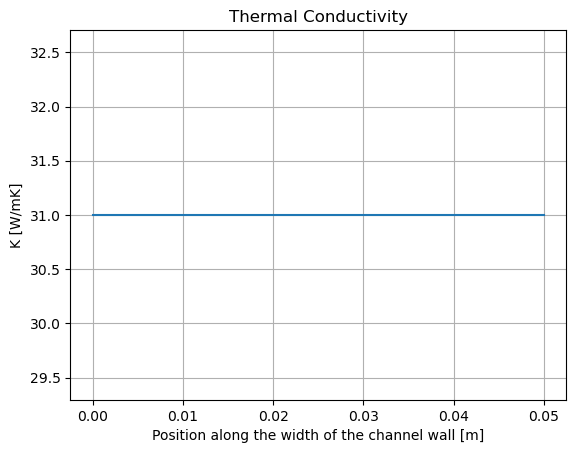

In [150]:
'''Thermal conductivity'''
#Cond_shape_pts = [(0,31.93),(0.05,29.94)]
tc_pts = [(0,31),(0.05,31)] #thermal conductivity between the two channels 
therm_cond=np.array(tc_pts) 

k_cond=interp1d(therm_cond[:,0],therm_cond[:,1])

plt.figure()
plt.plot(np.linspace(0,0.05,200),k_cond(np.linspace(0,0.05,200)),label='Target Function')
plt.title('Thermal Conductivity') 
plt.xlabel("Position along the width of the channel wall [m]")
plt.ylabel("K [W/mK]") 
plt.grid()
plt.show()

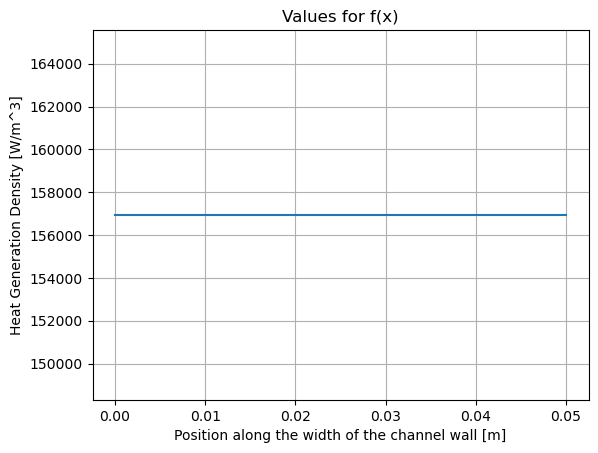

In [151]:
'''Source bias'''
#Use of points to build f(x) 
#Using constant heat generation 

heat_gen_pts = [(0,156940),(0.05,156940)] #Values of heat generation across the domain 
heat_source=np.array(heat_gen_pts)

func_x=interp1d(heat_source[:,0],heat_source[:,1])

plt.figure()
plt.plot(np.linspace(0,0.05,200),func_x(np.linspace(0,0.05,200)),label='Target Function')
plt.title('Values for f(x)') 
plt.xlabel("Position along the width of the channel wall [m]") 
plt.ylabel("Heat Generation Density [W/m^3]") 
plt.grid()
plt.show()

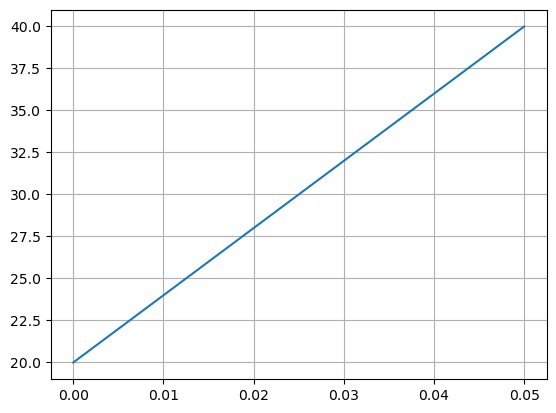

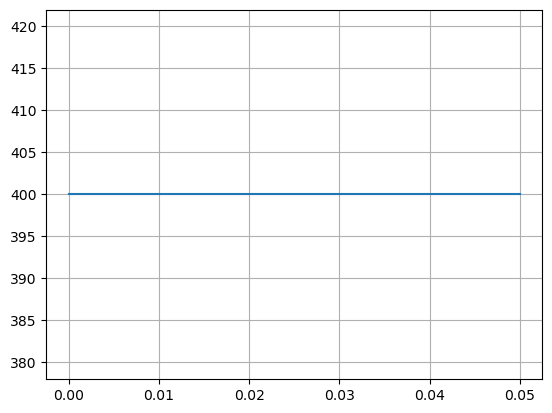

In [152]:
'''Building the lift function'''
u_a=20 #temperature at point a
u_b=40 #temperature at point b

delta_temp = [(0,u_a),(0.05,u_b)] #temperature distribution across the domain channel from a to b  
temperature=np.array(delta_temp)
temp_func=interp1d(temperature[:,0],temperature[:,1])

temp_func_prime=((u_b-u_a)/(x_max-x_min)) #Change in temperature over change in postion 
Lift_prime_shape_pts = [(0,temp_func_prime),(0.05,temp_func_prime)]
Lift_prime=np.array(Lift_prime_shape_pts)
f_lift_prime=interp1d(Lift_prime[:,0],Lift_prime[:,1])

plt.figure()
plt.plot(np.linspace(0,0.05,200),temp_func(np.linspace(0,0.05,200)))
plt.title("Change in temperature across the domain")
plt.xlable("Position along the width of the channel [m]") 
plt.ylable("Temperature [C]") 
plt.grid()
plt.show()

plt.figure()
plt.plot(np.linspace(0,0.05,200),f_lift_prime(np.linspace(0,0.05,200)))
plt.grid()
plt.show()

In [153]:
'''FEM Solution'''
'''Domain partition'''
def get_domain_partition(degree, n_elem, x_min, x_max, bc_x_min='flux', bc_x_max='flux'):
    #assert degree == 1
    # Local node numbering on parent domain
    # --0--------------1---->
    #  -1      0      +1    zetta
    gnodes_x = np.linspace(x_min, x_max, n_elem*degree+1, dtype=np.float64)
    patches = list()
    local_to_global_node_id_map = list()
    for e in range(n_elem):
        gnode_id_1 = degree*e   #left
        gnode_id_2 = degree*e+1 #center
        gnode_id_3 = degree*e+2 #right
        x1 = gnodes_x[gnode_id_1]
        x2 = gnodes_x[gnode_id_2]
        x3 = gnodes_x[gnode_id_3]
        # Local node id:  0   1
        patches.append((x1, x2, x3))
        # Local node id:                        0           2             1
        local_to_global_node_id_map.append([gnode_id_1, gnode_id_2,  gnode_id_3])
    if bc_x_min == 'essential':
        local_to_global_node_id_map[0][0] = -1
    if bc_x_max == 'essential':
        local_to_global_node_id_map[-1][-1] = -1
    return (patches, gnodes_x, local_to_global_node_id_map)

domain_partition = get_domain_partition(degree, n_elem, x_min, x_max)
parent_mapping = get_parent_mapping()
parent_basis_functions = get_parent_basis_functions()

phi_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[0]
phi_prime_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[1]

In [154]:
#Building of the A matrix
A_mtrx = np.zeros((len(phi_list), len(phi_list)), dtype=np.float64)
patches = domain_partition[0]
for i in range(len(phi_list)):
    for j in range(len(phi_list)):
        
        phi_i=phi_list[i]
        phi_j=phi_list[j]
        
        phi_prime_i=phi_prime_list[i]
        phi_prime_j=phi_prime_list[j]
        
        h_e=(x_max-x_min)/n_elem
        
        d_x_phi_prime_j = lambda x: k_cond(x) * ((2/h_e)*phi_prime_j(x))
        
        prima = lambda x: phi_prime_i(x)*(2/h_e)
        
        A_mtrx[i,j] = inner_product(prima, d_x_phi_prime_j, patches) + htc*phi_i(x_min)*phi_j(x_min) + htc*phi_i(x_max)*phi_j(x_max)

In [155]:
'''Build load vector'''
#The load vector
b_vec = np.zeros(len(phi_list), dtype=np.float64)
patches = domain_partition[0]

for i in range(len(phi_list)):
    phi_i=phi_list[i]
    phi_prime_i=phi_prime_list[i]
    
    b_vec[i] = inner_product(f_sourcebias, phi_i, patches)-htc*(f_lift(x_max)-u_b)*phi_i(x_max)-htc*(f_lift(x_min)-u_a)*phi_i(x_min)
    
    first_term = lambda x: f_lift_prime(x)*k_cond(x)
    phi_prima_i = lambda x: phi_prime_i(x)*(2/h_e)
    
    b_vec[i] -= inner_product(first_term, phi_prima_i, patches)

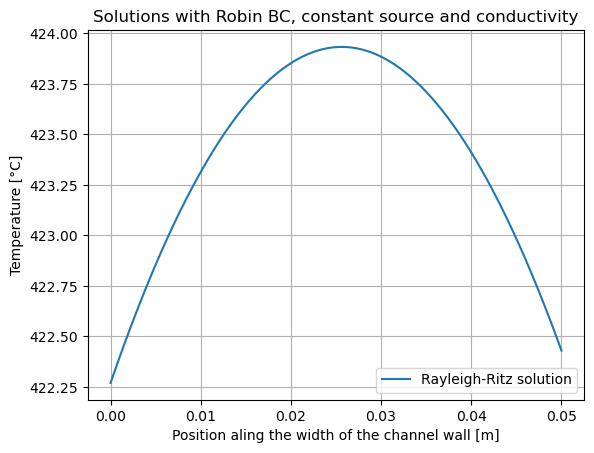

The value of the function at the leftmost end of the domain is: 422.27 [°C].
The value of the function at the rightmost end of the domain is: 422.43 [°C].


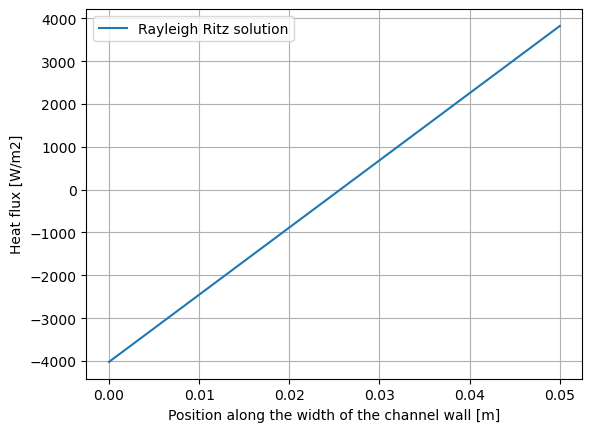

q_na computed =  [-4022.69999999]
q_nb computed =  [3824.3]


In [156]:
'''Solution'''
'''Compute optimal coefficient vector'''
c_star_vec = np.linalg.solve(A_mtrx, b_vec)

'''Plot comparison of f and g_best_vec'''
def u_star(x):
    g_x=f_lift(x)
    for (j,phi_i) in enumerate(phi_list):
        g_x=g_x+(c_star_vec[j])*phi_i(x)
    return g_x
    
def u_star_prime(x):
    g_x=f_lift_prime(x)
    for j in range(len(phi_list)):
        g_x=g_x+(c_star_vec[j])*((2/h_e)*phi_prime_list[j](x))
    return g_x

plt.figure()
plt.plot(np.linspace(x_min,x_max,2000),u_star(np.linspace(x_min,x_max,2000)),label='Rayleigh-Ritz solution')
plt.title('Solutions with Robin BC, constant source and conductivity')
#plt.plot(np.linspace(x_min,x_max,2000),sol(np.linspace(x_min,x_max,2000)),label='Analytic solution')
plt.xlabel("Position aling the width of the channel wall [m]")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid()
plt.show()

print('The value of the function at the leftmost end of the domain is: %4.2f [°C].'%u_star(x_min))
print('The value of the function at the rightmost end of the domain is: %4.2f [°C].'%u_star(x_max))

#Plotting the flux
plt.figure()
plt.plot(np.linspace(x_min,x_max,2000),-k_cond(np.linspace(x_min,x_max,2000))*u_star_prime((np.linspace(x_min,x_max,2000))),label='Rayleigh Ritz solution')
plt.xlabel("Position along the width of the channel wall [m]")
plt.ylabel("Heat flux [W/m2]")
plt.legend()
plt.grid()
plt.show()

'''Flux at boundary'''
print('q_na computed = ', -k_cond(x_min)*u_star_prime(x_min))
print('q_nb computed = ', -k_cond(x_max)*u_star_prime(x_max))

#print(sol(np.linspace(x_min,x_max,2000)))

#print('q_nb given    = ', q_nb)
#print('flux error [%]= ',(-f_cond(x_max)*g_prime(x_max) - q_nb)/q_nb*100)